In [ ]:
def euler_sir(S0, I0, R0, alpha, beta, T):
  N = S0
  S = [S0]
  I = [I0]
  R = [R0]
  dt = 0.01

  for i in range(int(T/dt)):
    dS = -beta * S[-1] * (I[-1] / N)
    dI = beta * S[-1] * (I[-1] / N) - alpha * I[-1]
    dR = alpha * I[-1]
    S.append(S[-1] + dt * dS)
    I.append(I[-1] + dt * dI)
    R.append(R[-1] + dt * dR)
  #downsample
  S_downsampled = S[::100]
  I_downsampled = I[::100]
  R_downsampled = R[::100]
  return S_downsampled, I_downsampled, R_downsampled

In [ ]:
def objective(x, target_vector, scaled_vector,norm):
  diff = target_vector - x * scaled_vector
  return np.linalg.norm(diff, ord=norm)

In [ ]:
# p = 1
def p1minimize(measured,estimated):
  fs = []
  max = len(measured) - 1
  for i in range(max):
    if estimated[i] != 0:
      rk = measured[i]/estimated[i]
      if rk >= 0 and rk <= 1:
        fk = 0
        for j in range(max):
          fk += abs(measured[j] - rk*estimated[j])
        fs.append((fk,i))
  fs.sort()
  if len(fs) != 0:
    #print(fs[0])
    min_index = fs[0][1]
    min = measured[min_index]/estimated[min_index]
    return min
  return math.inf

In [ ]:
# p = 2
def p2minimize(measured,estimated):
  num = 0
  denom = 0
  for k in range(len(measured)):
    num += measured[k]*estimated[k]
    denom += abs(estimated[k])**2
  est = num/denom
  if est < 0:
    return 0
  elif est > 1:
    return 1
  else:
    return est

In [ ]:
# p = inf
import numpy as np
from scipy.optimize import linprog

def pinfminimize(measured,estimated):
  length = 2*len(measured)
  #negative one column
  A_l = -1*np.ones((2*length,1))
  A_r = np.ones((2*length,1))
  b = np.zeros((2*length,1))
  for i in range(0,length,4):
    A_r[int(i/2),0] = -1*estimated[int(i/2)]
    A_r[int(i/2) + 1,0] = estimated[int(i/2)]
    b[int(i/2),0] = -1*measured[int(i/2)]
    b[int(i/2) + 1,0] = measured[int(i/2)]
  f = np.array([[1],[0]])
  x0_bnds = (0,math.inf)
  x1_bnds = (0,1)
  A = np.hstack((A_l,A_r))
  result = linprog(f, A_ub = A, b_ub = b, bounds = (x0_bnds,x1_bnds), method = 'highs')
  if result.x[1] == 1:
    return math.inf
  return result.x[1]

In [ ]:
def Jobjfunc(alpha, beta, gamma, rho, It, Yt, Isim, Rsim, order, ci, cy):
  if order == 1:
    #print("1")
    lsum = 0
    rsum = 0
    for i in range(len(It)):
      lsum += abs(It[i] - rho*Isim[i])
      rsum += abs(Yt[i] - gamma*Rsim[i])
    if ci != 0:
      lsum = ci*lsum
      rsum = cy*rsum
      return lsum+rsum
    else:
      return rsum
  elif order == 2:
    #print("2")
    lsum = 0
    rsum = 0
    for i in range(len(It)):
      lsum += (abs(It[i] - rho*Isim[i]))**2
      rsum += (abs(Yt[i] - gamma*Rsim[i]))**2
    if ci != 0:
      lsum = ci*lsum
      rsum = cy*rsum
      return lsum+rsum
    else:
      return rsum
  elif order == math.inf:
    #print("inf")
    lmax = 0
    rmax = 0
    for i in range(len(It)):
      if abs(It[i] - rho*Isim[i]) > lmax:
        lmax = abs(It[i] - rho*Isim[i])
      if abs(Yt[i] - gamma*Rsim[i]) > rmax:
        rmax =  abs(Yt[i] - gamma*Rsim[i])
    if ci != 0:
      lmax = ci*lmax
      lmax = cy*lmax
      return lmax+rmax
    else:
      return rmax

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import linprog

excel_file = "teamhw2data.xlsx"
#excel_file = "Validation.xlsx"
df = pd.read_excel(excel_file,header=None)

array = df.to_numpy()
cum_infect = array[1]
cum_death = array[2]

# DEFINING CONSTANTS
S0 = 259547
#S0 = 705749 #N

R0 = 0
Tmax = 40
Vmin = 5
tau = 7

CI = 1
CY = 1

##############################################################
# 1)
#t0 = 63
#Dc
t0 = 55


#Time series of infection rates
It = np.zeros(Tmax)
for i in range (0,Tmax):
  It[i] = cum_infect[i + t0 + tau] - cum_infect[i + t0 - tau]
#print(It)
I0 = It[0]
#aligned cumulative death
Y_measured = np.zeros(Tmax)
for i in range(0,Tmax):
  Y_measured[i] = cum_death[i + t0]
#print(Y_measured)

#storage
J_1_storage = []
J_2_storage = []
J_inf_storage = []
alpha_beta_I_R = []
numloops = 0
#alpha loop
for a in np.arange(.05,0.41,.01):
  alpha = round(a,2)

  #R loop
  for r in np.arange(0.8,2.25,.05):
    numloops = numloops+1
    Rzed = round(r,2)
    beta = alpha*Rzed
    beta = round(beta,5)

    S, I, R = euler_sir(S0 = S0, I0 = I0, R0 = R0, alpha= alpha ,beta=beta, T= Tmax)

    alpha_beta_I_R.append((alpha,beta,I,R))

    # find the gamma for R and rho for I
    gamma_1 = p1minimize(Y_measured,R)
    #print(gamma_1)
    gamma_2 = p2minimize(Y_measured,R)
    #print(gamma_2)
    gamma_inf = pinfminimize(Y_measured,R)
    #print(gamma_inf)

    rho_1 = p1minimize(It,I)
    #print(rho_1)

    rho_2 = p2minimize(It,I)
    #print(rho_2)
    rho_inf = pinfminimize(It,I)
    #print(rho_inf)
    J1 = Jobjfunc(alpha = alpha,beta = beta,gamma = gamma_1,rho = rho_1, It = It, Yt = Y_measured, Isim = I, Rsim = R, order = 1, ci = CI, cy = CY)
    if gamma_1 != math.inf and rho_1 != math.inf and  gamma_1 != 1 and rho_1 != 1:
      J_1_storage.append((J1, alpha, beta, gamma_1, rho_1, I, R))

    J2 = Jobjfunc(alpha = alpha,beta = beta,gamma = gamma_2,rho = rho_2, It = It, Yt = Y_measured, Isim = I, Rsim = R, order = 2, ci = CI, cy = CY)
    if gamma_2 != math.inf and rho_2 != math.inf and gamma_2 != 1 and rho_2 != 1:
      J_2_storage.append((J2, alpha, beta, gamma_2, rho_2, I, R))

    Jinf = Jobjfunc(alpha = alpha,beta = beta,gamma = gamma_inf,rho = rho_inf, It = It, Yt = Y_measured, Isim = I, Rsim = R, order = math.inf, ci = CI, cy = CY)
    if gamma_inf != math.inf and rho_inf != math.inf and gamma_inf != 1 and rho_inf != 1:
      J_inf_storage.append((Jinf, alpha, beta, gamma_inf, rho_inf, I, R))

In [ ]:
J_1_storage.sort()
J_2_storage.sort()
J_inf_storage.sort()
print("For ci=1 cy=1:")
print("Joptimal , alpha_hat, beta_hat, gamma_hat, rho_hat, I, R")
print(J_1_storage[0])
print(J_2_storage[0])
print(J_inf_storage[0])

For ci=1 cy=1:
Joptimal , alpha_hat, beta_hat, gamma_hat, rho_hat, I, R
(4607.102391701719, 0.32, 0.704, 0.0001997289844837181, 0.012299875017983224, [4.0, 5.8682395163363585, 8.608961846382241, 12.629511794243658, 18.527286684593523, 27.1782598963238, 39.86656661613879, 58.47400214109043, 85.75670970154003, 125.74826503191052, 184.34494441206544, 270.1513225658376, 395.69299615512335, 579.1365453661087, 846.6876716867656, 1235.8469761062975, 1799.6428992410204, 2611.7368503163293, 3771.7280884174083, 5408.7943117776385, 7679.675658689437, 10753.965878851786, 14777.040345381474, 19802.89291486921, 25702.867807869552, 32085.593134193827, 38293.07202807891, 43526.854888858725, 47080.006021506604, 48557.99782202392, 47966.13994162708, 45637.90659476424, 42077.09896483164, 37805.83614774997, 33267.99953980262, 28791.288259905297, 24588.839840597884, 20779.732987421427, 17414.288353546635, 14496.990195042423, 12004.470798717546], [0, 1.5568849064025092, 3.8409155636865897, 7.191660198037455

In [ ]:
#Fredrick
S_1,I_1,R_1 = euler_sir(S0 = 259547, I0=It[0], R0=0, alpha = 0.32, beta=0.704, T=1021)
S_2,I_2,R_2 = euler_sir(S0 = 259547, I0=It[0], R0=0, alpha = 0.33, beta=0.726, T=1021)
S_inf,I_inf,R_inf = euler_sir(S0 = 259547, I0=It[0], R0=0, alpha = 0.33, beta=0.726, T=1021)

In [ ]:
#DC
S_1,I_1,R_1 = euler_sir(S0 = 705749, I0=It[0], R0=0, alpha = 0.35, beta=0.4375, T=1030)
S_2,I_2,R_2 = euler_sir(S0 = 705749, I0=It[0], R0=0, alpha = .33, beta=0.4215, T=1030)
S_inf,I_inf,R_inf = euler_sir(S0 = 705749, I0=It[0], R0=0, alpha = .4, beta=0.66, T=1030)

In [ ]:
def find_infection_down_time(Isim, Vmin):
    for i,elt in enumerate(Isim):
      if elt <= Vmin:
        return i
    return None
print(find_infection_down_time(I_1,5))
print(It[find_infection_down_time(I_1,5)])
print(find_infection_down_time(I_2,5))
print(It[find_infection_down_time(I_2,5)])
print(find_infection_down_time(I_inf,5))
print(It[find_infection_down_time(I_inf,5)])

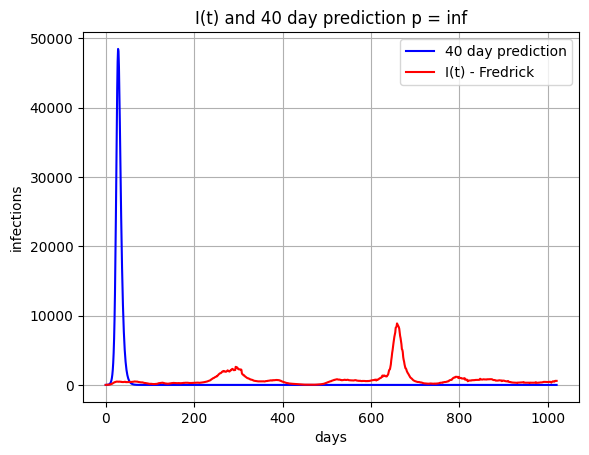

4.0
0


In [ ]:
I_1_plot = []
Ireal = []
It = np.zeros(1021)
for i in range (0,1021):
  It[i] = cum_infect[i + t0 + tau] - cum_infect[i + t0 - tau]

for i in range(1021):
  I_1_plot.append((i,I_inf[i]))
  Ireal.append((i,It[i]))

x_1, y_1 = zip(*I_1_plot)
xinfect, yinfect = zip(*Ireal)
plt.plot(x_1, y_1, label = "40 day prediction", color='blue')
plt.plot(xinfect, yinfect, label = "I(t) - Fredrick", color='red')
plt.xlabel('days')
plt.ylabel('infections')
plt.title('I(t) and 40 day prediction p = inf' )
plt.legend()
plt.grid(True)
plt.show()

min = math.inf
minindex = 0

for t in range(1021):
  if It[t] < min:
    minindex = t
    min = It[t]
print(min)
print(minindex)

In [ ]:
#3d graphs
gamma_1 = J_1_storage[0][3]
rho_1 = J_1_storage[0][4]

gamma_2 = J_2_storage[0][3]
rho_2 = J_2_storage[0][4]

gamma_inf = J_inf_storage[0][3]
rho_inf = J_inf_storage[0][4]

points_2d_1 = []
points_2d_2 = []
points_2d_inf = []

for elt in alpha_beta_I_R:
  (a,b,Isim,Rsim) = elt
  J_1 = Jobjfunc(alpha = a, beta = b, gamma = gamma_1, rho = rho_1, It = It, Yt = Y_measured, Isim = Isim, Rsim = Rsim, order = 1, ci = CI, cy = CY)
  J_2 = Jobjfunc(alpha = a, beta = b, gamma = gamma_2, rho = rho_2, It = It, Yt = Y_measured, Isim = Isim, Rsim = Rsim, order = 2, ci = CI, cy = CY)
  J_inf = Jobjfunc(alpha = a, beta = b, gamma = gamma_inf, rho = rho_inf, It = It, Yt = Y_measured, Isim = Isim, Rsim = Rsim, order = math.inf, ci = CI, cy = CY)

  points_2d_1.append((a,b,J_1))
  points_2d_2.append((a,b,J_2))
  points_2d_inf.append((a,b,J_inf))

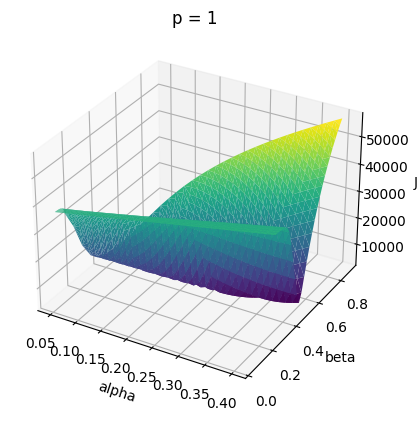

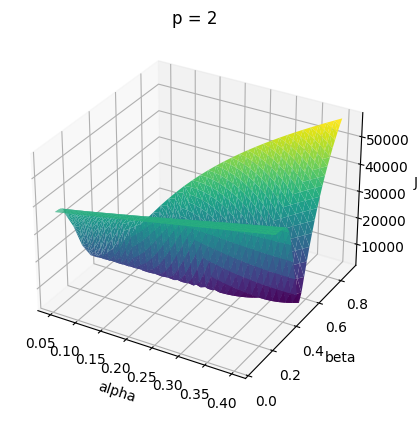

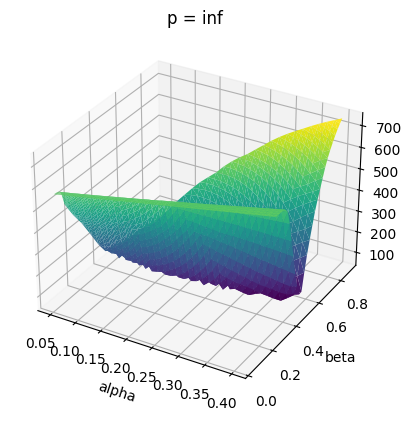

In [ ]:
X_1,Y_1,Z_1 = zip(*points_2d_1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X_1, Y_1, Z_1, cmap='viridis', edgecolor='none')

# Set labels and title
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('J')
ax.set_title('p = 1')

# Show the plot
plt.show()

X_2,Y_2,Z_2 = zip(*points_2d_1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X_2, Y_2, Z_2, cmap='viridis', edgecolor='none')

# Set labels and title
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('J')
ax.set_title('p = 2')

# Show the plot
plt.show()

X_inf,Y_inf,Z_inf = zip(*points_2d_inf)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X_inf, Y_inf, Z_inf, cmap='viridis', edgecolor='none')

# Set labels and title
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('J')
ax.set_title('p = inf')

# Show the plot
plt.show()

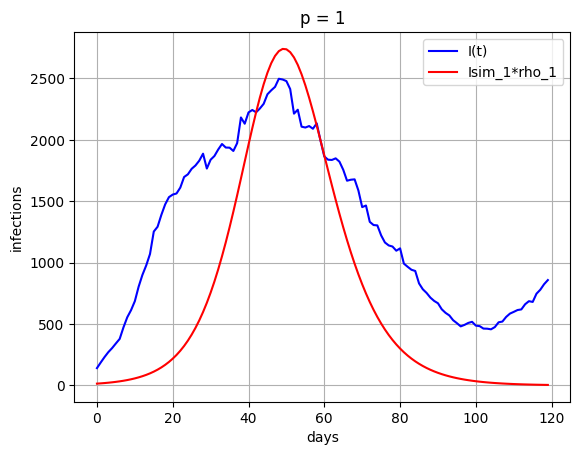

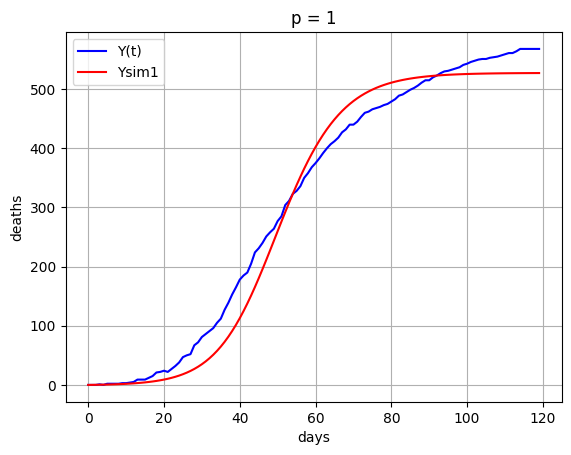

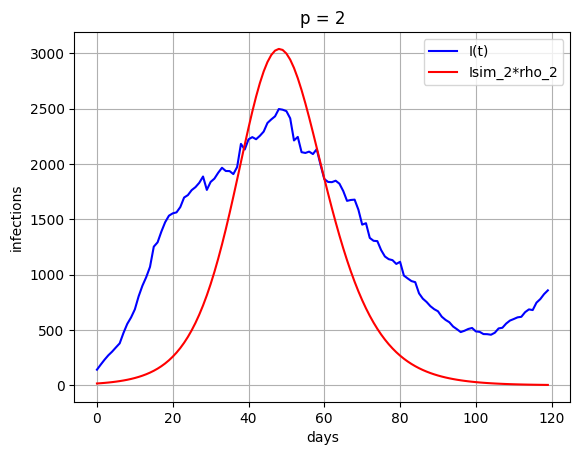

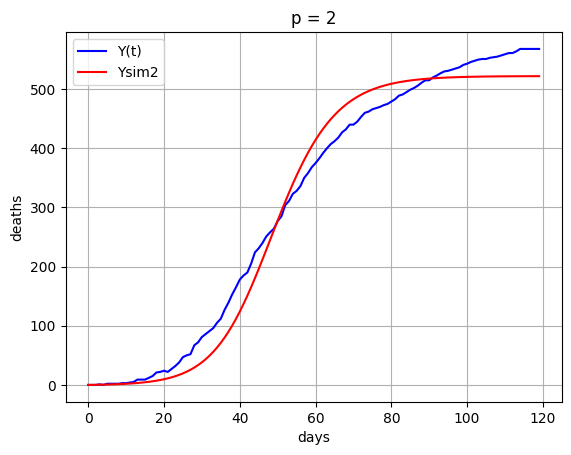

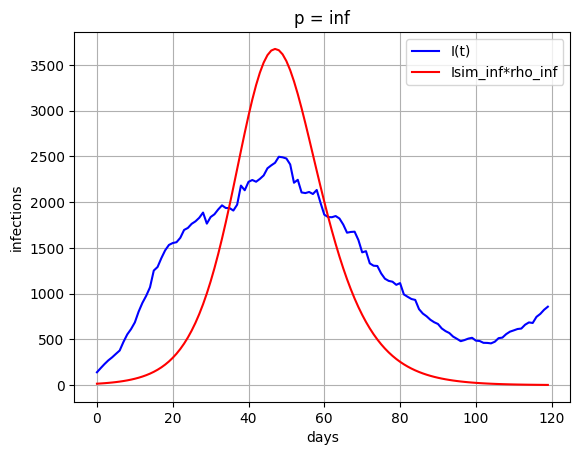

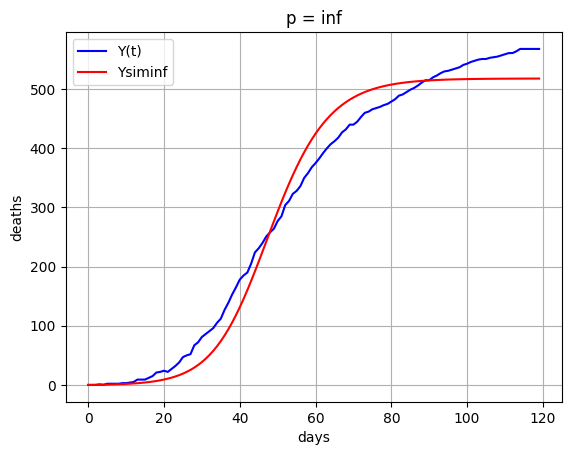

In [ ]:
Isim1 = J_1_storage[0][5]
Rsim1 = np.array(J_1_storage[0][6])

Isim2 = J_2_storage[0][5]
Rsim2 = np.array(J_2_storage[0][6])

Isiminf = J_inf_storage[0][5]
Rsiminf = np.array(J_inf_storage[0][6])

gammaRsim1 = gamma_1 * Rsim1
gammaRsim2 = gamma_2 * Rsim2
gammaRsiminf = gamma_inf * Rsiminf

I_plot = []
Y_plot = []
I_sim_1 = []
gammaR_sim_1 = []
I_sim_2 = []
gammaR_sim_2 = []
I_sim_inf = []
gammaR_sim_inf = []

for i in range(Tmax):
  I_plot.append((i,It[i]))
  Y_plot.append((i,Y_measured[i]))

  I_sim_1.append((i,rho_1*Isim1[i]))
  gammaR_sim_1.append((i,gamma_1*Rsim1[i]))

  I_sim_2.append((i,rho_2*Isim2[i]))
  gammaR_sim_2.append((i,gamma_2*Rsim2[i]))
  I_sim_inf.append((i,rho_inf*Isiminf[i]))
  gammaR_sim_inf.append((i,gamma_inf*Rsiminf[i]))


xinfect, yinfect = zip(*I_plot)
xremove, yremove = zip(*Y_plot)
# p = 1
xi,yi = zip(*I_sim_1)
xr,yr = zip(*gammaR_sim_1)

plt.plot(xinfect, yinfect, label='I(t)', color='blue')
plt.plot(xi, yi, label='Isim_1*rho_1', color='red')
plt.xlabel('days')
plt.ylabel('infections')
plt.title('p = 1')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(xremove, yremove, label='Y(t)', color='blue')
plt.plot(xr, yr, label='Ysim1', color='red')
plt.xlabel('days')
plt.ylabel('deaths')
plt.title('p = 1')
plt.legend()
plt.grid(True)
plt.show()

xi,yi = zip(*I_sim_2)
xr,yr = zip(*gammaR_sim_2)

plt.plot(xinfect, yinfect, label='I(t)', color='blue')
plt.plot(xi, yi, label='Isim_2*rho_2', color='red')
plt.xlabel('days')
plt.ylabel('infections')
plt.title('p = 2')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(xremove, yremove, label='Y(t)', color='blue')
plt.plot(xr, yr, label='Ysim2', color='red')
plt.xlabel('days')
plt.ylabel('deaths')
plt.title('p = 2')
plt.legend()
plt.grid(True)
plt.show()

xi,yi = zip(*I_sim_inf)
xr,yr = zip(*gammaR_sim_inf)

plt.plot(xinfect, yinfect, label='I(t)', color='blue')
plt.plot(xi, yi, label='Isim_inf*rho_inf', color='red')
plt.xlabel('days')
plt.ylabel('infections')
plt.title('p = inf')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(xremove, yremove, label='Y(t)', color='blue')
plt.plot(xr, yr, label='Ysiminf', color='red')
plt.xlabel('days')
plt.ylabel('deaths')
plt.title('p = inf')
plt.legend()
plt.grid(True)
plt.show()